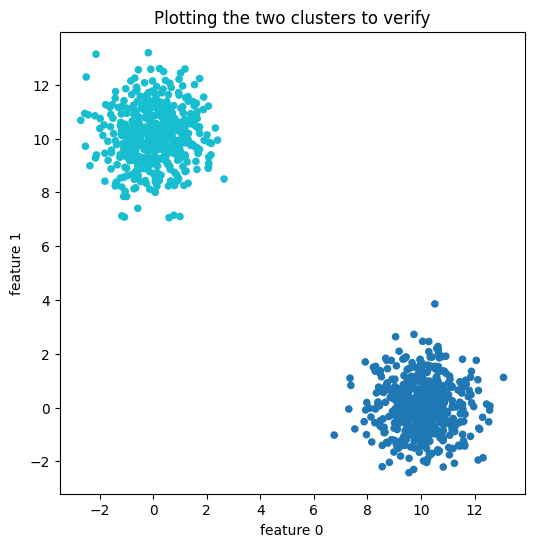

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples = [500, 500],
    centers = [(10, 0), (0, 10)],
    n_features = 2,
    random_state = 42,
    cluster_std = 1.0
)

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=20)
plt.title("Plotting the two clusters to verify")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
plt.show()

In [2]:
### PLOT HELPER FUNCTIONS ###

import numpy as np

def _detect_polarity(scores, y_pred):
    """Return True if larger score means more anomalous (based on means)."""
    mean_in = scores[y_pred == 0].mean() if np.any(y_pred == 0) else np.nan
    mean_out = scores[y_pred == 1].mean() if np.any(y_pred == 1) else np.nan
    return np.isnan(mean_out) or (mean_out > mean_in)

def prepare_scores(model, X_test, res=300, pad=1.0):
    """
    Compute normalized grid and point anomaly scores for plotting.
    Returns: XX, YY, grid_norm (2D), point_norm (1D), y_pred (1D)
    """
    y_pred = model.predict(X_test)
    test_scores = model.decision_function(X_test)
    larger_means_anomalous = _detect_polarity(test_scores, y_pred)
    raw_points = test_scores if larger_means_anomalous else -test_scores

    x_min, x_max = X_test[:, 0].min() - pad, X_test[:, 0].max() + pad
    y_min, y_max = X_test[:, 1].min() - pad, X_test[:, 1].max() + pad
    xx = np.linspace(x_min, x_max, res)
    yy = np.linspace(y_min, y_max, res)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.c_[XX.ravel(), YY.ravel()]

    grid_scores = model.decision_function(grid)
    grid_raw = grid_scores if larger_means_anomalous else -grid_scores

    global_min = min(raw_points.min(), grid_raw.min())
    global_max = max(raw_points.max(), grid_raw.max())
    eps = 1e-12
    grid_norm = (grid_raw - global_min) / (global_max - global_min + eps)
    point_norm = (raw_points - global_min) / (global_max - global_min + eps)

    return XX, YY, grid_norm.reshape(XX.shape), point_norm, y_pred

def plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred=None,
                          cmap_grid='coolwarm', cmap_points='viridis',
                          title='Decision surface', show_outliers=True, ax=None):
    """
    Plot contour heatmap and scatter of points colored by normalized score.
    Optionally highlights predicted outliers (y_pred == 1).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    else:
        fig = ax.figure

    cf = ax.contourf(XX, YY, grid_norm, levels=100, cmap=cmap_grid, alpha=0.6)
    sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=point_norm, cmap=cmap_points,
                    s=25, edgecolors='k', linewidth=0.3)
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('normalized anomaly score (1 = most anomalous)')

    ax.set_title(title)
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    return fig, ax

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'IsolationForest'}, xlabel='feature 0', ylabel='feature 1'>)

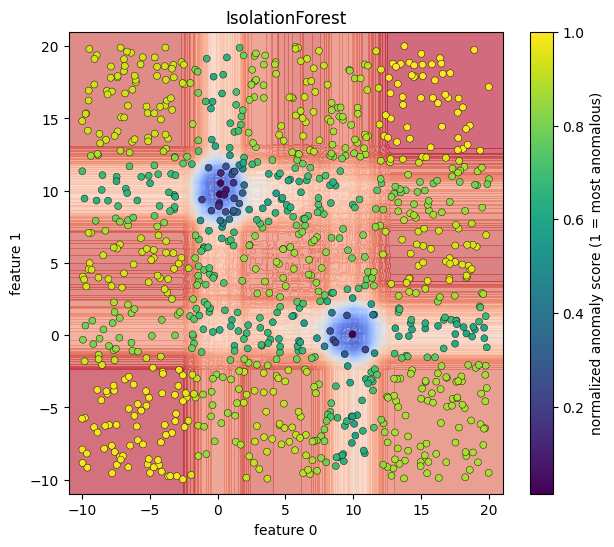

In [3]:
from pyod.models.iforest import IForest

contamination = 0.2
iforest_model = IForest(contamination = contamination, random_state = 42)
iforest_model.fit(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred_iforest = iforest_model.predict(X_test)
test_scores_iforest = iforest_model.decision_function(X_test)


XX, YY, grid_norm, point_norm, y_pred = prepare_scores(iforest_model, X_test, res=300, pad=1.0)
plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred, title='IsolationForest')


(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'DIF'}, xlabel='feature 0', ylabel='feature 1'>)

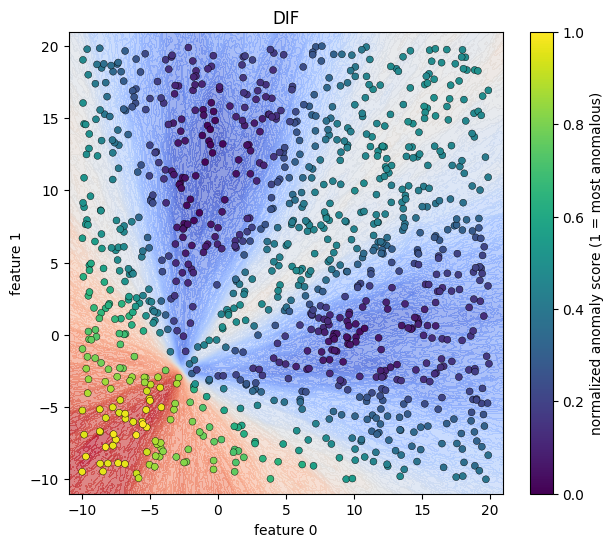

In [4]:
from pyod.models.dif import DIF
from pyod.models.loda import LODA


dif_model = DIF(contamination = contamination, random_state = 42)
dif_model.fit(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred_dif = dif_model.predict(X_test)
test_scores_dif = dif_model.decision_function(X_test)


XX, YY, grid_norm, point_norm, y_pred = prepare_scores(dif_model, X_test, res=300, pad=1.0)
plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred, title='DIF')

(<Figure size 700x600 with 2 Axes>,
 <Axes: title={'center': 'LODA'}, xlabel='feature 0', ylabel='feature 1'>)

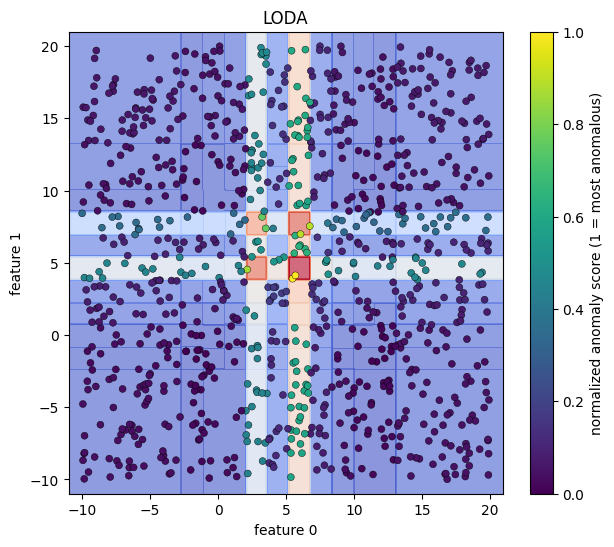

In [5]:
loda_model = LODA(contamination = contamination)
loda_model.fit(X)

X_test = np.random.uniform(low = -10, high = 20, size = (1000,2))
y_test_pred_loda = loda_model.predict(X_test)
test_scores_loda = loda_model.decision_function(X_test)


XX, YY, grid_norm, point_norm, y_pred = prepare_scores(loda_model, X_test, res=300, pad=1.0)
plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred, title='LODA')

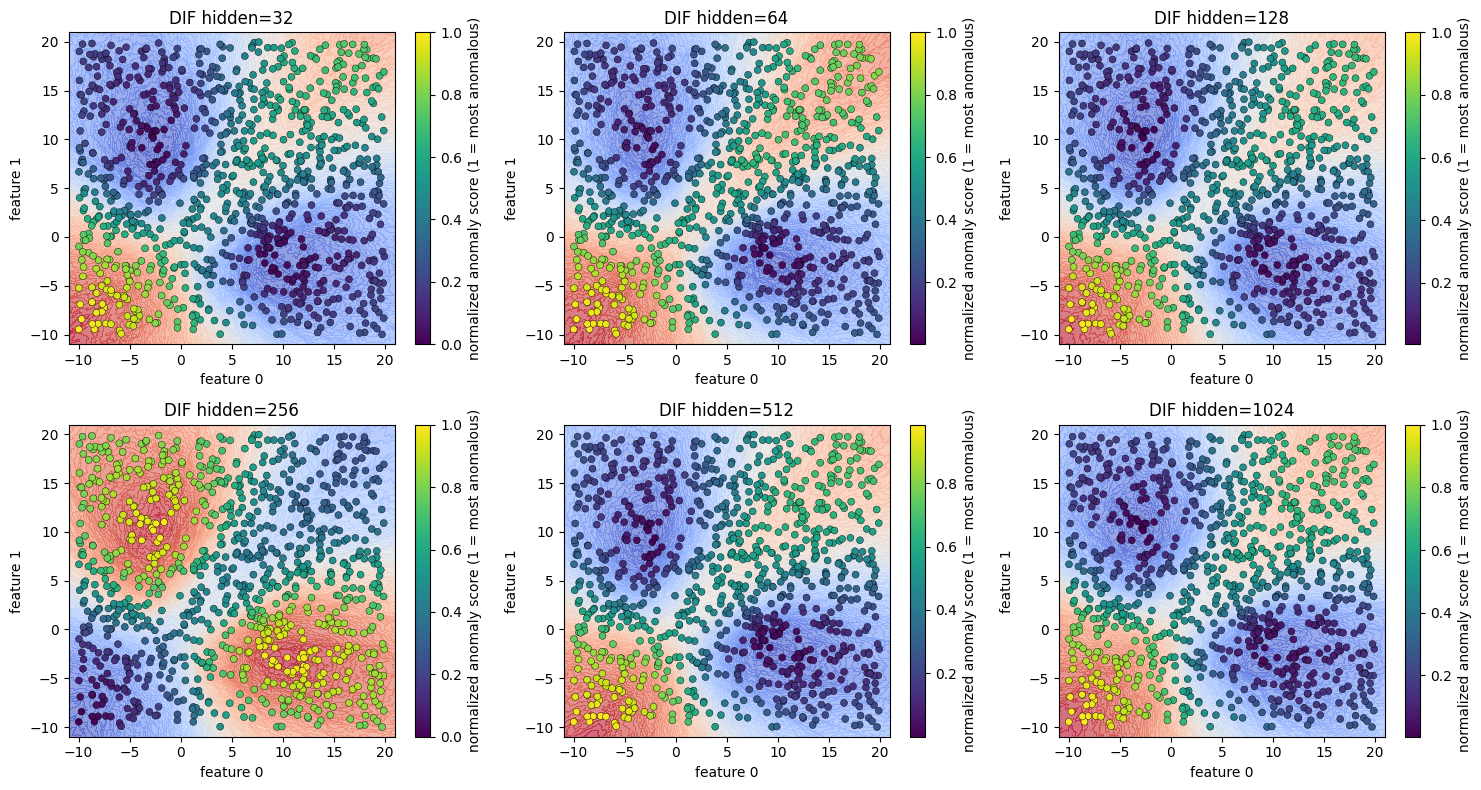

In [14]:
# using different number of neurons in hidden layers
# for DIF

neuron_counts = [32, 64, 128, 256, 512, 1024]
n_plots = len(neuron_counts)
ncols = 3
nrows = (n_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, n in enumerate(neuron_counts):
    ax = axes[i]
    dif_model = DIF(contamination=contamination, random_state=42, hidden_neurons=[n])
    dif_model.fit(X)

    X_test = np.random.uniform(low=-10, high=20, size=(1000, 2))
    y_test_pred_dif = dif_model.predict(X_test)
    test_scores_dif = dif_model.decision_function(X_test)

    XX, YY, grid_norm, point_norm, y_pred = prepare_scores(dif_model, X_test, res=300, pad=1.0)
    plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred,
                          title=f'DIF hidden={n}', ax=ax)


plt.tight_layout()
plt.show()

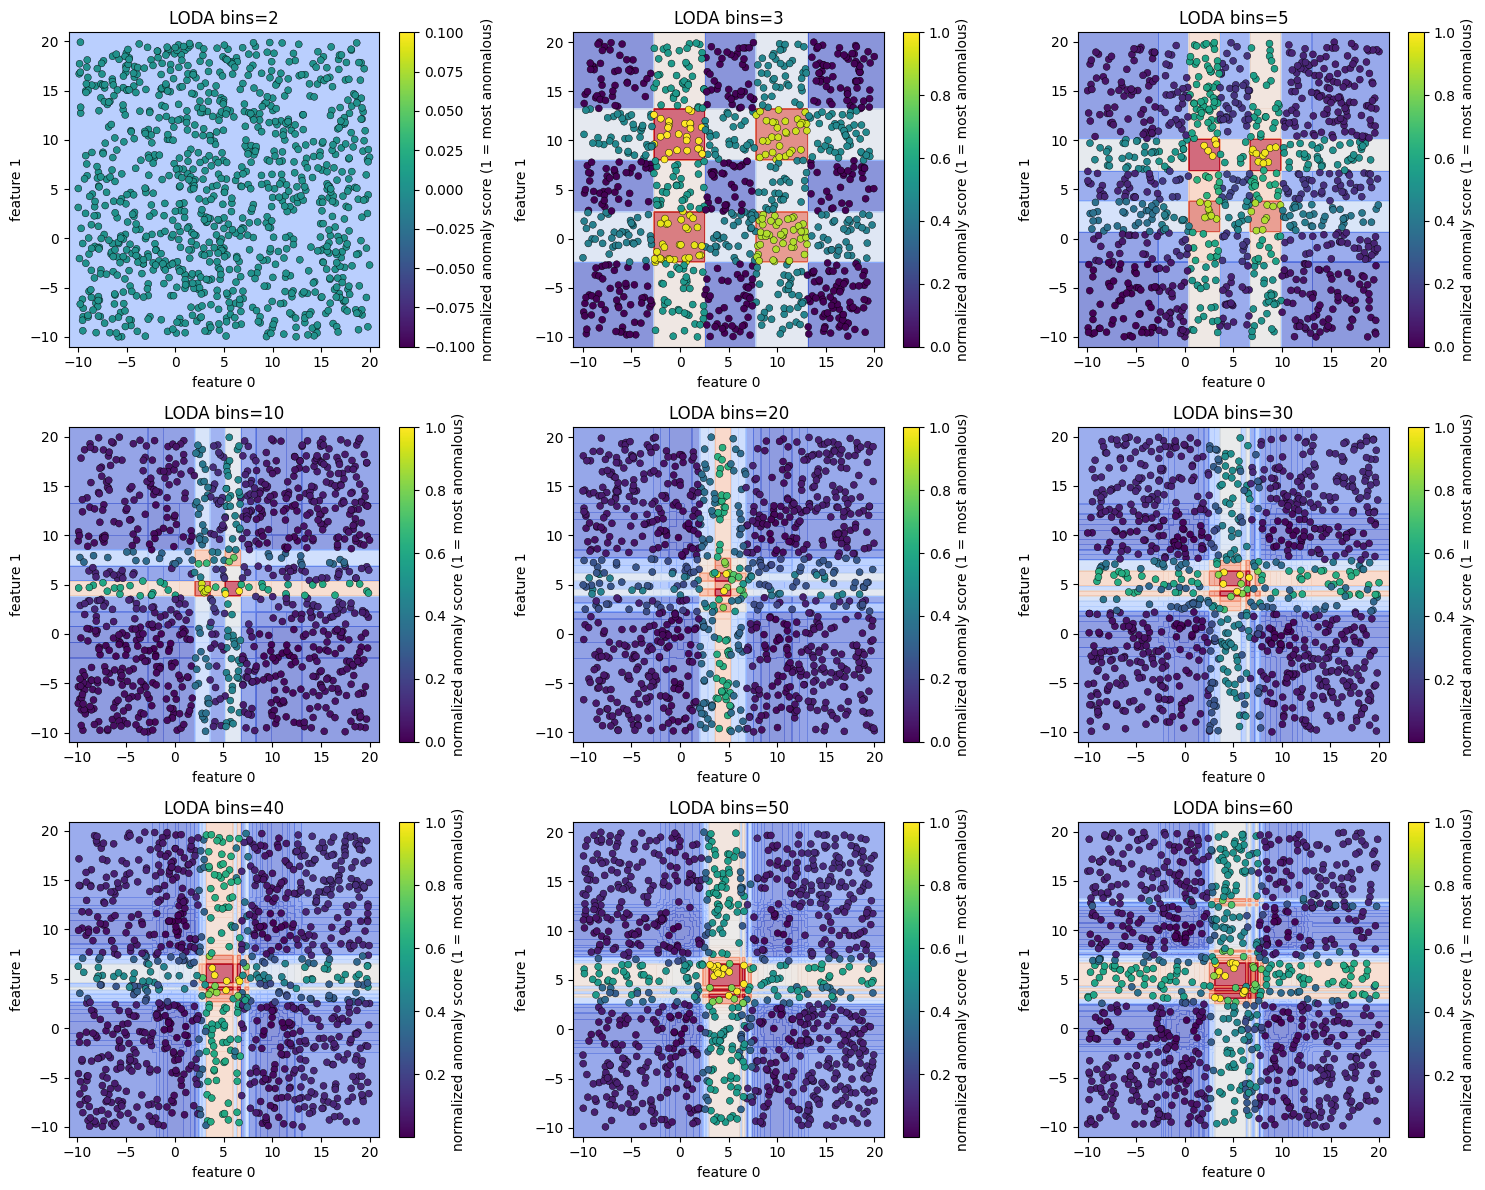

In [18]:
# using different number of bins for LODA

bin_counts = [2, 3, 5, 10, 20, 30, 40, 50, 60]
n_plots = len(bin_counts)
ncols = 3
nrows = (n_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, n in enumerate(bin_counts):
    ax = axes[i]
    loda_model = LODA(contamination=contamination, n_bins=n)
    loda_model.fit(X)

    X_test = np.random.uniform(low=-10, high=20, size=(1000, 2))
    y_test_pred_loda = loda_model.predict(X_test)
    test_scores_loda = loda_model.decision_function(X_test)

    XX, YY, grid_norm, point_norm, y_pred = prepare_scores(loda_model, X_test, res=300, pad=1.0)
    plot_decision_surface(XX, YY, grid_norm, X_test, point_norm, y_pred,
                          title=f'LODA bins={n}', ax=ax)


plt.tight_layout()
plt.show()

LODA seems to not work properly if the number of bins is equal to the number of features, as there is no division in the score map. At bins = 3 we see the first true separation, but it does fail to capture enough information about the data. The anomaly separation seems to get better and better as we increase the number of bins, but at bins = 60, the score map begins to have undesired effects. A sweet spot for our data looks to be with bins between 30 and 40.

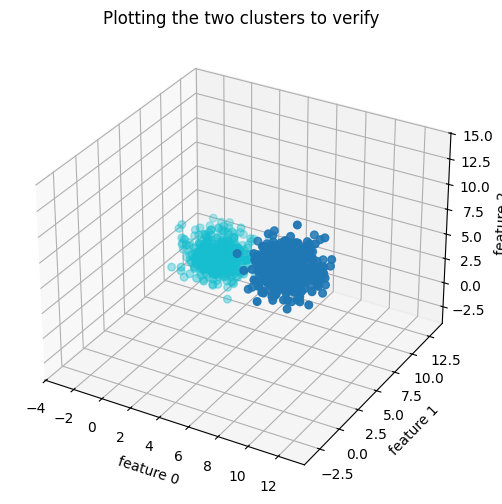

In [24]:
### Repeat the experiments but in 3D

X, y = make_blobs(
    n_samples = [500, 500],
    centers = [(10, 0, 10), (0, 10, 0)],
    n_features = 3,
    random_state = 42,
    cluster_std = 1.0
)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10', s=30)
ax.set_title("Plotting the two clusters to verify")
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.set_zlabel("feature 2")
plt.show()

In [26]:
def _detect_polarity(scores, y_pred):
    """Return True if larger score means more anomalous (based on means)."""
    mean_in = scores[y_pred == 0].mean() if np.any(y_pred == 0) else np.nan
    mean_out = scores[y_pred == 1].mean() if np.any(y_pred == 1) else np.nan
    return np.isnan(mean_out) or (mean_out > mean_in)

def prepare_scores_3d(model, X_test, res=50, pad=1.0):
    """
    Compute normalized grid and point anomaly scores for 3D plotting.
    Returns: XX, YY, ZZ, grid_norm (3D), point_norm (1D), y_pred (1D)
    """
    y_pred = model.predict(X_test)
    test_scores = model.decision_function(X_test)
    larger_means_anomalous = _detect_polarity(test_scores, y_pred)
    raw_points = test_scores if larger_means_anomalous else -test_scores

    x_min, x_max = X_test[:, 0].min() - pad, X_test[:, 0].max() + pad
    y_min, y_max = X_test[:, 1].min() - pad, X_test[:, 1].max() + pad
    z_min, z_max = X_test[:, 2].min() - pad, X_test[:, 2].max() + pad
    
    xx = np.linspace(x_min, x_max, res)
    yy = np.linspace(y_min, y_max, res)
    zz = np.linspace(z_min, z_max, res)
    XX, YY, ZZ = np.meshgrid(xx, yy, zz)
    grid = np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()]

    grid_scores = model.decision_function(grid)
    grid_raw = grid_scores if larger_means_anomalous else -grid_scores

    global_min = min(raw_points.min(), grid_raw.min())
    global_max = max(raw_points.max(), grid_raw.max())
    eps = 1e-12
    grid_norm = (grid_raw - global_min) / (global_max - global_min + eps)
    point_norm = (raw_points - global_min) / (global_max - global_min + eps)

    return XX, YY, ZZ, grid_norm.reshape(XX.shape), point_norm, y_pred

def plot_decision_surface_3d(X_test, point_norm, y_pred=None,
                             cmap_points='viridis', title='3D Decision surface',
                             ax=None, alpha=0.6):
    """
    Plot 3D scatter of points colored by normalized anomaly score.
    Optionally highlights predicted outliers (y_pred == 1).
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
    else:
        fig = ax.figure

    sc = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], 
                    c=point_norm, cmap=cmap_points,
                    s=30, edgecolors='k', linewidth=0.3, alpha=alpha)
    
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('normalized anomaly score (1 = most anomalous)')

    ax.set_title(title)
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set_zlabel('feature 2')
    
    return fig, ax

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'IsolationForest 3D'}, xlabel='feature 0', ylabel='feature 1', zlabel='feature 2'>)

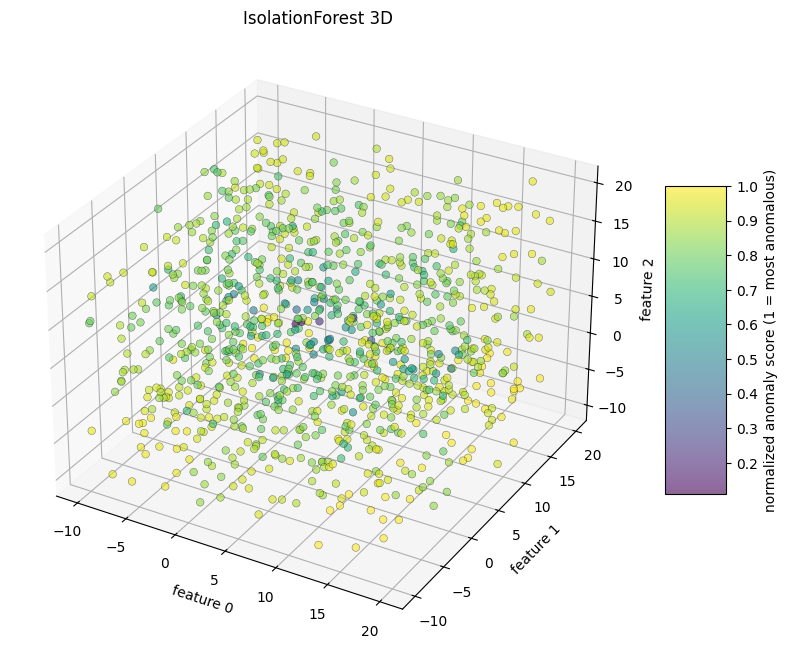

In [28]:
iforest_model_3d = IForest(contamination = contamination, random_state = 42)
iforest_model_3d.fit(X)

X_test_3d = np.random.uniform(low = -10, high = 20, size = (1000, 3))
y_test_pred_iforest_3d = iforest_model_3d.predict(X_test_3d)
test_scores_iforest_3d = iforest_model_3d.decision_function(X_test_3d)


XX, YY, ZZ, grid_norm, point_norm, y_pred_3d = prepare_scores_3d(iforest_model_3d, X_test_3d, res=50, pad=1.0)
plot_decision_surface_3d(X_test_3d, point_norm, y_pred_3d, title='IsolationForest 3D')

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'DIF 3D'}, xlabel='feature 0', ylabel='feature 1', zlabel='feature 2'>)

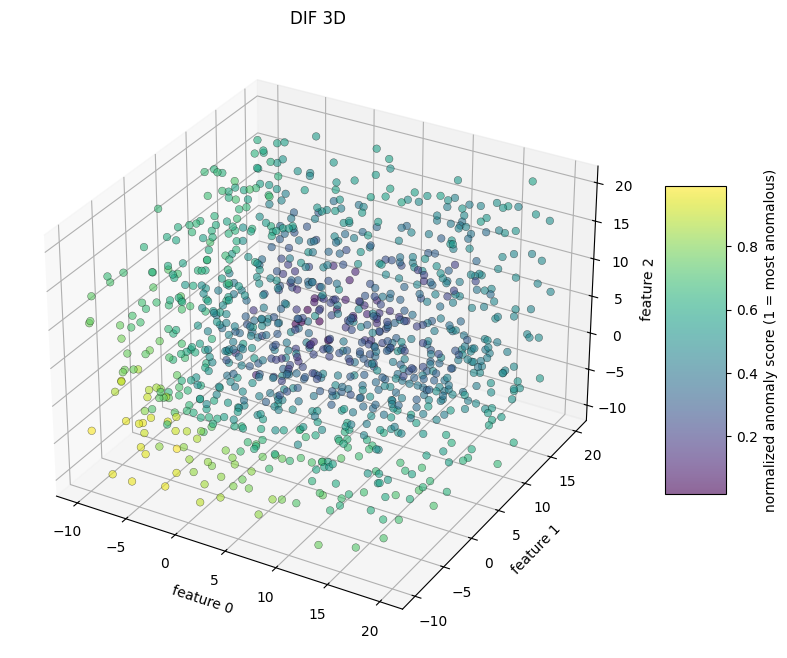

In [29]:
dif_model_3d = DIF(contamination = contamination, random_state = 42)
dif_model_3d.fit(X)

y_test_pred_dif_3d = dif_model_3d.predict(X_test_3d)
test_scores_dif_3d = dif_model_3d.decision_function(X_test_3d)


XX, YY, ZZ, grid_norm, point_norm, y_pred_3d = prepare_scores_3d(dif_model_3d, X_test_3d, res=50, pad=1.0)
plot_decision_surface_3d(X_test_3d, point_norm, y_pred_3d, title='DIF 3D')

(<Figure size 1000x800 with 2 Axes>,
 <Axes3D: title={'center': 'LODA 3D'}, xlabel='feature 0', ylabel='feature 1', zlabel='feature 2'>)

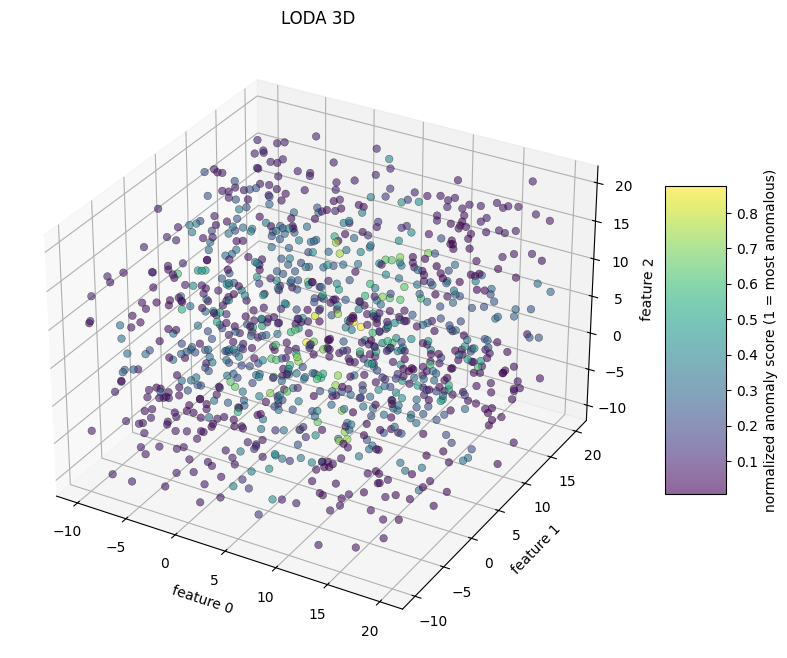

In [30]:
loda_model_3d = LODA(contamination = contamination)
loda_model_3d.fit(X)

y_test_pred_loda_3d = loda_model_3d.predict(X_test_3d)
test_scores_loda_3d = loda_model_3d.decision_function(X_test_3d)


XX, YY, ZZ, grid_norm, point_norm, y_pred_3d = prepare_scores_3d(loda_model_3d, X_test_3d, res=50, pad=1.0)
plot_decision_surface_3d(X_test_3d, point_norm, y_pred_3d, title='LODA 3D')